 Using device: cuda
 Classes: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']
 Loading VGG19 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 220MB/s] 


 Starting training...

 Epoch 1/10
 Train Loss: 0.7166, Train Acc: 71.15%
 Val Loss: 0.2703, Val Acc: 90.78%

 Epoch 2/10
 Train Loss: 0.2519, Train Acc: 90.76%
 Val Loss: 0.2350, Val Acc: 91.88%

 Epoch 3/10
 Train Loss: 0.1889, Train Acc: 92.85%
 Val Loss: 0.2891, Val Acc: 91.33%

 Epoch 4/10
 Train Loss: 0.1687, Train Acc: 93.71%
 Val Loss: 0.1805, Val Acc: 93.81%

 Epoch 5/10
 Train Loss: 0.1101, Train Acc: 95.77%
 Val Loss: 0.2323, Val Acc: 94.50%

 Epoch 6/10
 Train Loss: 0.1216, Train Acc: 95.84%
 Val Loss: 0.2681, Val Acc: 93.95%

 Epoch 7/10
 Train Loss: 0.1143, Train Acc: 95.98%
 Val Loss: 0.2962, Val Acc: 90.65%

 Epoch 8/10
 Train Loss: 0.1117, Train Acc: 96.29%
 Val Loss: 0.2312, Val Acc: 94.64%

 Epoch 9/10
 Train Loss: 0.0669, Train Acc: 97.53%
 Val Loss: 0.1775, Val Acc: 93.67%

 Epoch 10/10
 Train Loss: 0.0658, Train Acc: 97.59%
 Val Loss: 0.2507, Val Acc: 95.32%

 Final Test Accuracy: 94.92%


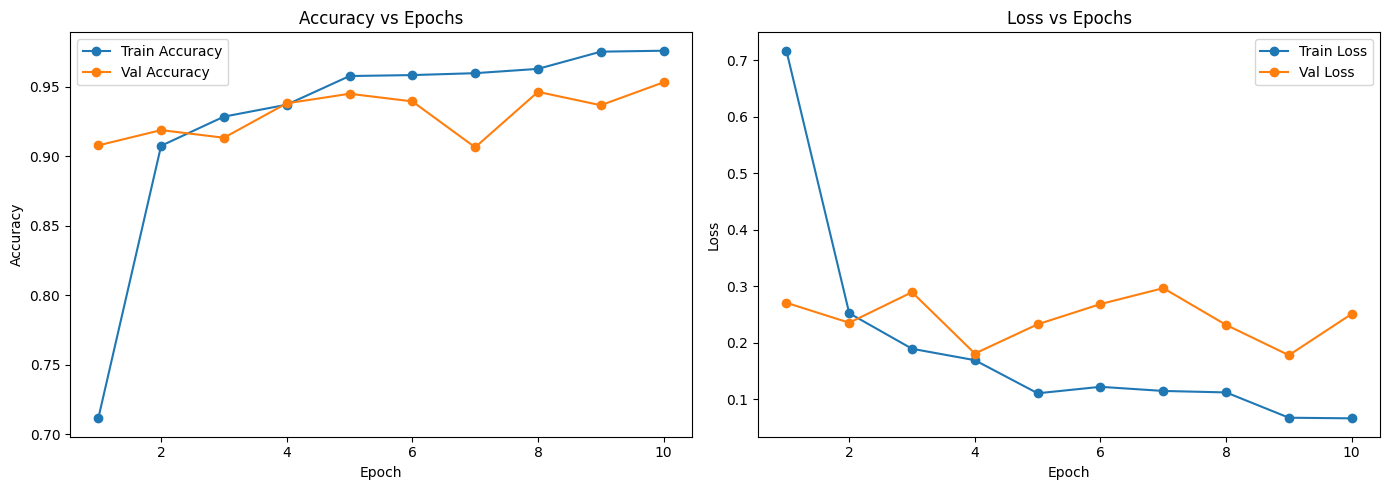

In [2]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

# Dataset path
data_dir = '/kaggle/input/multi-class-driver-behavior-image-dataset/Multi-Class Driver Behavior Image Dataset'

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
num_classes = len(full_dataset.classes)
print(" Classes:", full_dataset.classes)

# Split into train (80%), val (10%), test (10%)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Model setup
print(" Loading VGG19 model...")
model = models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Tracking history
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
num_epochs = 10
print(" Starting training...")
for epoch in range(num_epochs):
    print(f"\n Epoch {epoch + 1}/{num_epochs}")
    
    # Training
    model.train()
    running_loss = 0.0
    correct_train = total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    correct = total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f" Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f" Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Final test evaluation
model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"\n Final Test Accuracy: {test_acc:.2f}%")

# Plot results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'o-', label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


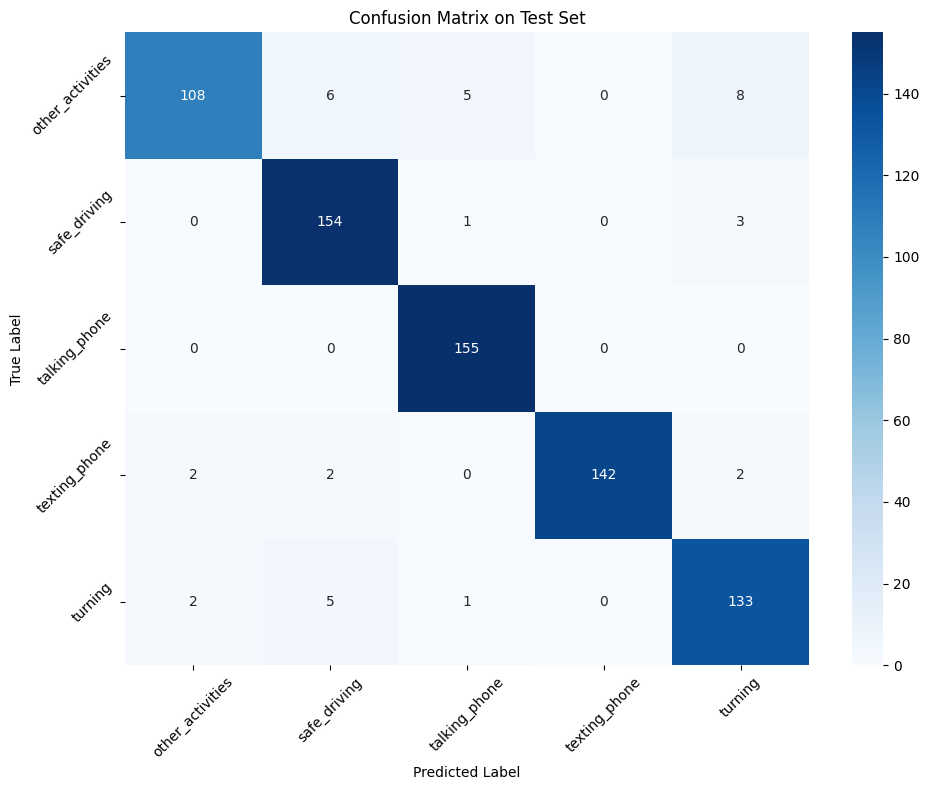

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
# Collect all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# Save model to output directory
model_path = '/kaggle/working/vgg19_driver_behavior.pth'
torch.save(model.state_dict(), model_path)
print(f"💾 Model saved to: {model_path}")

💾 Model saved to: /kaggle/working/vgg19_driver_behavior.pth


In [7]:
###### from sklearn.metrics import roc_auc_score
import time
import numpy as np

# Final test evaluation with AUC and inference time
model.eval()
correct = total = 0
all_labels = []
all_probs = []
inference_times = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        start_time = time.time()
        outputs = model(images)
        end_time = time.time()

        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        inference_times.append(end_time - start_time)
        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

test_acc = correct / total * 100
avg_infer_time = np.mean(inference_times)

# Concatenate tensors
all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()

# AUC score
try:
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    print(f"📈 AUC (multi-class OVR): {auc:.4f}")
except Exception as e:
    print("❌ AUC calculation failed:", e)

print(f"🎯 Final Test Accuracy: {test_acc:.2f}%")
print(f"⏱️ Average Inference Time per Batch: {avg_infer_time:.4f} seconds")
print(f"⚡ Average Inference Time per Sample: {avg_infer_time / batch_size:.6f} seconds")


📈 AUC (multi-class OVR): 0.9975
🎯 Final Test Accuracy: 94.92%
⏱️ Average Inference Time per Batch: 0.0027 seconds
⚡ Average Inference Time per Sample: 0.000170 seconds
